In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt
import warnings
import seaborn as sns

In [2]:
# Remove when Theano is updated
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams["savefig.dpi"] = 150
plt.rcParams["figure.dpi"] = 150
plt.rcParams["font.size"] = 16
plt.rcParams['font.sans-serif'] = ['Arial']

In [4]:
fontsize = 30
label_size = 20
tick_size = 15

plt.rcParams['font.size'] = fontsize
plt.rcParams['axes.titlesize'] = label_size
plt.rcParams['axes.labelsize'] = label_size
plt.rcParams['xtick.labelsize'] = tick_size
plt.rcParams['ytick.labelsize'] = tick_size
plt.rcParams['figure.titlesize'] = fontsize

# Download the Data

In [5]:
kepler_ref = 2454833
villanovaEB_ref = 2400000 

In [6]:
KIC = 4544587
lit_period = 2.189094
lit_t0 = 2455462.006137 - 2454833 # Dan's version

Other measured parameters

In [7]:
# ******** from Villanova EB database ********
#lit_period = 2.1890973
#lit_t0 = 54954.135787 + villanova_tref-kepler_tref # Time of eclipse. Convention s.t. the primary (deeper) eclipse occurs at phase 0 (BJD-2400000)'
lit_R1 = 2.416
lit_R1_err = 0.6325
mu_R1 = np.log(lit_R1**2/np.sqrt((lit_R1**2 + lit_R1_err**2)))

pdepth = 0.4479 #in flux units
sdepth = 0.324  
pwidth = 2*0.1724  #in Phase units (it seems to be 1/2 the eclipse duration, so that's why we multiply it by 2)
swidth = 2*0.1292  

In [8]:
# ******** from https://arxiv.org/pdf/1306.1819.pdf ********
lit_R2 = 1.58  
lit_a = 10.855 #[Rsun]
lit_i = np.radians(87.9) #[degrees] 
lit_e = 0.275 
lit_omega = 5.74 #[rad]

Retrieve all the existing short-cadence photometry on this system. 

In [9]:
lcfs = lk.search_lightcurvefile("KIC %s"%KIC, mission="Kepler", cadence="short").download_all()
lc = lcfs.SAP_FLUX.stitch().remove_nans().remove_outliers(sigma = 3, sigma_lower = float('inf'))

/Users/mbadenas/opt/anaconda3/envs/mit37_mkl/lib/python3.7/site-packages/lightkurve/lightcurvefile.py:47: LightkurveWarning: `LightCurveFile.header` is deprecated, please use `LightCurveFile.get_header()` instead.
  LightkurveWarning)


Use a subset of the data (for now) 

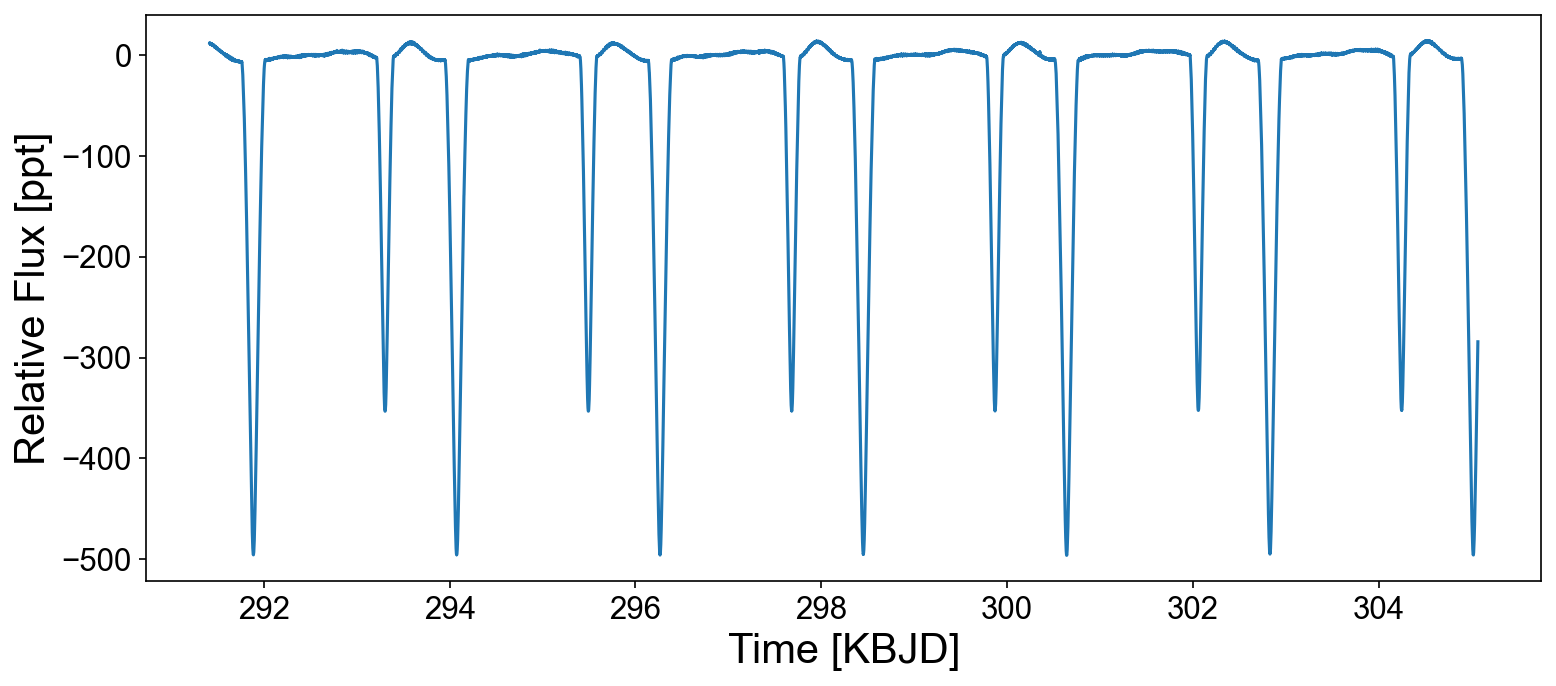

In [10]:
x = np.ascontiguousarray(lc.time[:20000], dtype=np.float64)
y = np.ascontiguousarray(lc.flux[:20000], dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err[:20000], dtype=np.float64)
mu = np.median(y)
y = (y / mu - 1) * 1e3

fig, ax = plt.subplots(1,1)
ax.plot(x,y) 
ax.set(xlabel = 'Time [KBJD]', ylabel = 'Relative Flux [ppt]');

Phase-fold the light curve

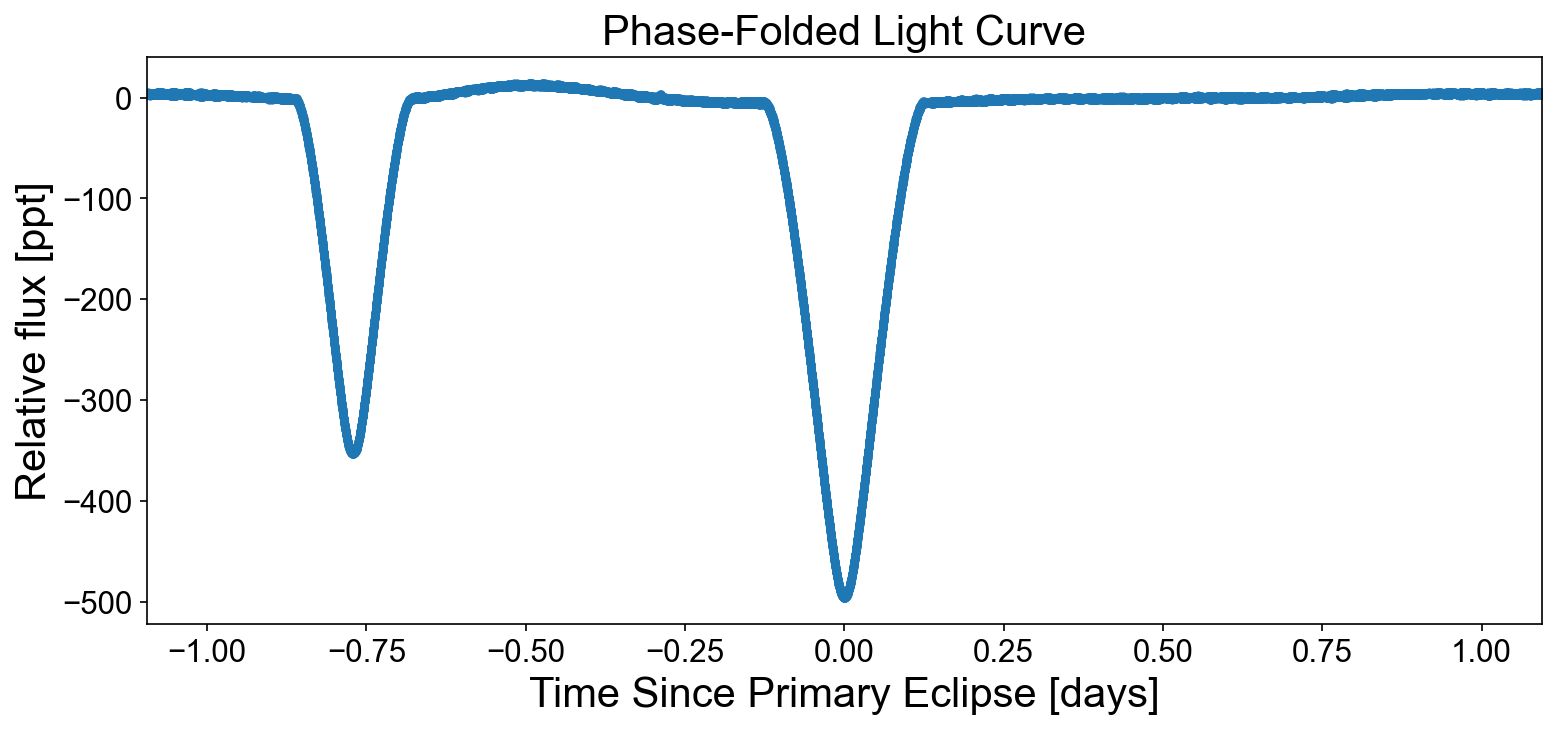

In [11]:
x_fold = (x - lit_t0 + 0.5 * lit_period) % lit_period - 0.5 * lit_period
    
fig, ax = plt.subplots(1,1)
ax.plot(x_fold, y, '.')
ax.set(
    xlim = (-0.5 * lit_period, 0.5 * lit_period), 
    xlabel = "Time Since Primary Eclipse [days]",
    ylabel = "Relative flux [ppt]",
    title = "Phase-Folded Light Curve"
);

# Estimate the Phase Curve

In [12]:
bin_edges = lit_period * np.linspace(-0.5, 0.5, 5000)
num, _ = np.histogram(x_fold, bin_edges, weights=y)
denom, _ = np.histogram(x_fold, bin_edges)

In [13]:
x_smooth = 0.5 * (bin_edges[1:] + bin_edges[:-1])
y_smooth = num / denom
m = np.abs(x_smooth) > 0.5
second_phase = x_smooth[m][np.argmin(y_smooth[m])]

x_smooth = np.concatenate(([2 * x_smooth[0] - x_smooth[1]], x_smooth, [2 * x_smooth[-1] - x_smooth[-2]]))
y_smooth = np.concatenate(([y_smooth[-1]], y_smooth, [y_smooth[0]]))
mod = np.interp(x_fold, x_smooth, y_smooth) 

Compute the out-of-eclipse residuals from this phase curve

In [14]:
mask = (np.abs(x_fold - second_phase) > 0.2) & (np.abs(x_fold) > 0.2)
resid = y - mod
sigma = np.median(resid[mask] ** 2)
mask[mask] &= np.abs(resid[mask]) < 20 * sigma

Plot smoothed phase curve

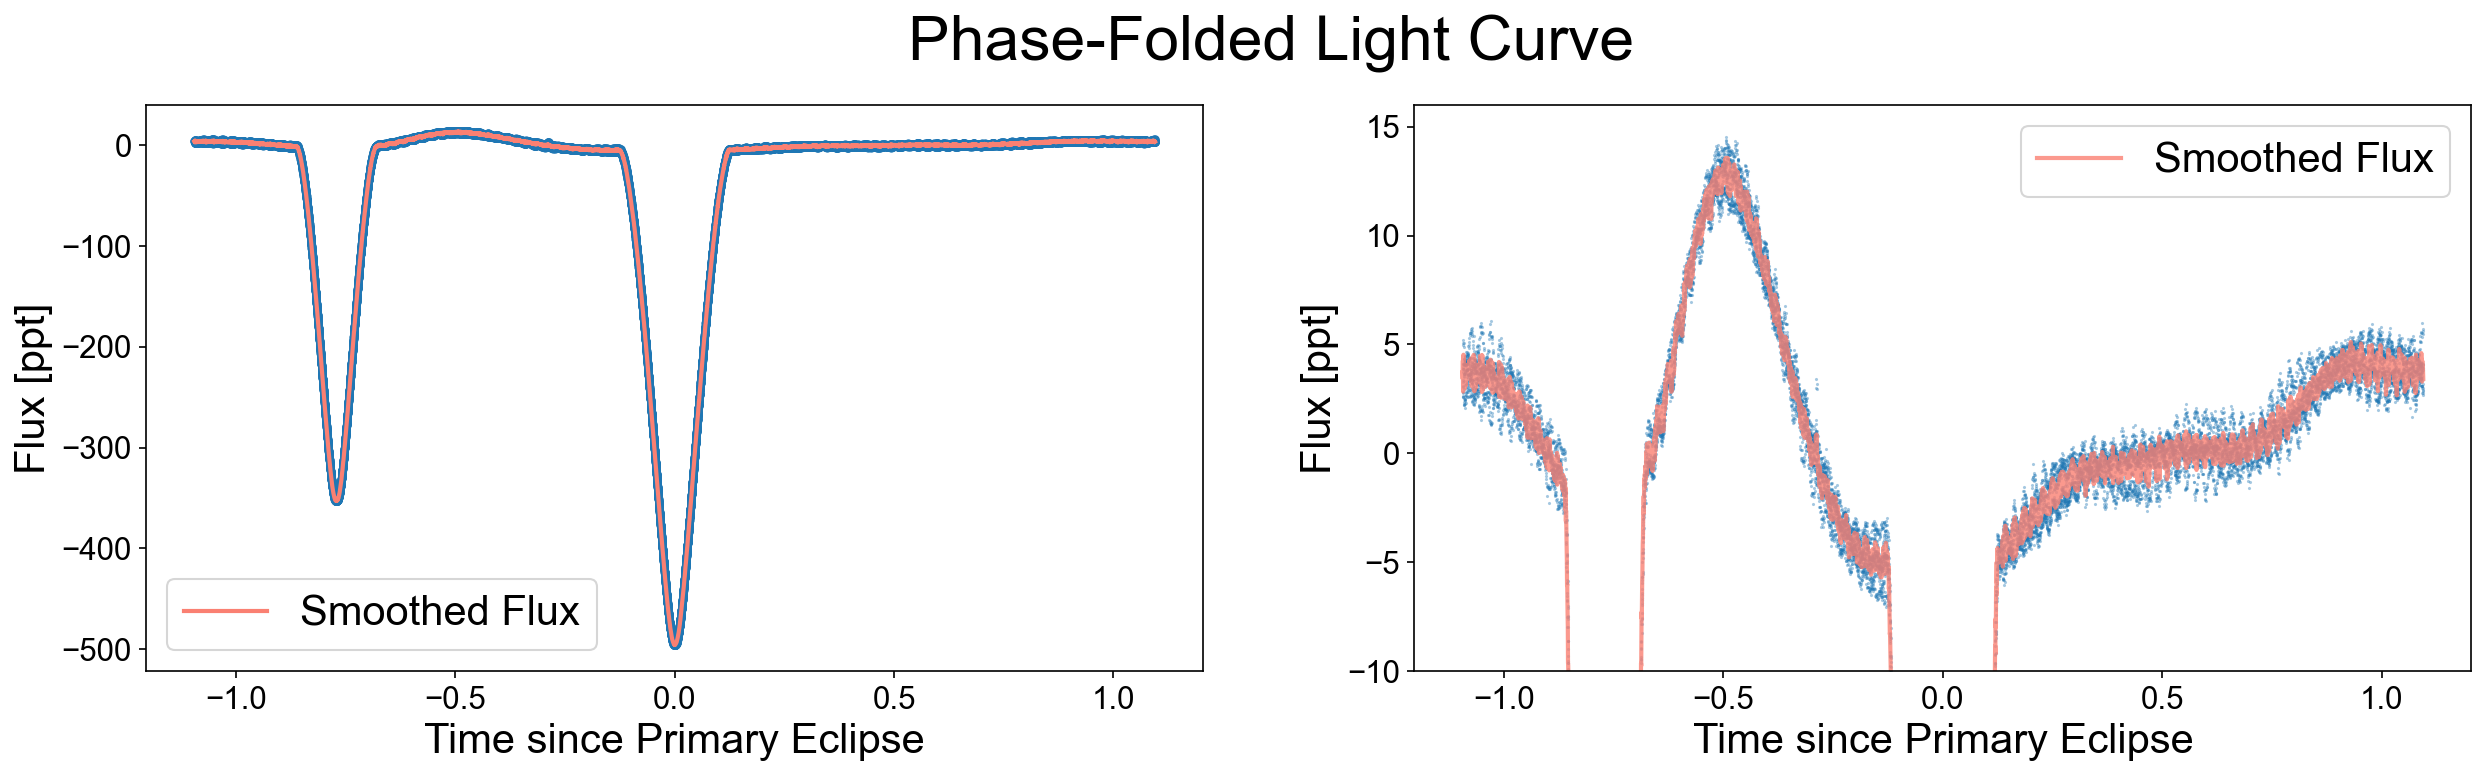

In [15]:
fig, ax = plt.subplots(1,2, sharex=True, figsize=(20,5))
fig.subplots_adjust(hspace=0.1)
fig.suptitle("Phase-Folded Light Curve",y=1.0)
ax[0].plot(x_fold,y, '.')
ax[0].plot(x_smooth, y_smooth, lw = 2, c = 'salmon', label = 'Smoothed Flux');
ax[0].legend(fontsize=20)
ax[0].set(xlabel = "Time since Primary Eclipse", ylabel="Flux [ppt]");
ax[1].plot(x_fold,y, '.', ms=1, alpha = 0.4)
ax[1].plot(x_smooth, y_smooth, lw = 2, c = 'salmon', alpha = 0.8, label = 'Smoothed Flux');
ax[1].set(xlabel = "Time since Primary Eclipse", ylabel="Flux [ppt]", ylim=(-10,16));
ax[1].legend(fontsize=20)

# Find 1st Batch of Oscillation Frequencies

In [16]:
def min2day(m): return m*6.944*(10**-4)
def hour2day(h): return h*0.04167

In [27]:
def freq2dhms(f): 
    if type(f) == int:
        d = 1./f
        print("f = %0.02f 1/d --> %0.04f days, %0.02f hours, %0.02f min, %0.02f sec" %(f, d, d*24, d*24.*60., d*24.*60.*60))
        
    else: 
        for freq in f:
            d = 1./freq
            print("f = %0.02f 1/d --> %0.04f days, %0.02f hours, %0.02f min, %0.02f sec" %(freq, d, d*24, d*24.*60., d*24.*60.*60))
        
def find_oscillations(time, flux, npeaks, minf, maxf, optional_it):
    res_ls = xo.estimators.lomb_scargle_estimator(
        time, 
        flux, 
        #samples_per_peak=100,
        max_peaks=npeaks, 
        min_period=1.0/maxf, 
        max_period=1.0/minf
    )
    
    #res_ls is a dictionary. The model of the periodogram is ls
    ls = res_ls["ls"]
    frequencies, powers = res_ls['periodogram']#[0], res_ls['periodogram'][1]
    periods = 1.0/frequencies
    best_frequency = frequencies[np.argmax(powers)]
    best_period = 1./best_frequency
    
    # Hack to remove nearby modes
    peak_freq = np.array([1.0/res_ls["peaks"][0]["period"]])
    peak_log_power = [res_ls["peaks"][0]["log_power"]]
    for peak in res_ls["peaks"][1:]:
        freq = 1.0 / peak["period"]
        if np.any(np.abs(peak_freq - freq) < 0.2):
            continue
        peak_freq = np.append(peak_freq, freq)
        peak_log_power.append(peak["log_power"])
    print(f"--> I have found {len(peak_freq)} frequencies")
    
    log_probs = np.array([-2, -4, -6, -8])
    fals = ls.false_alarm_level(10.**log_probs)
    
    # Find harmonics within dist_to_integer 
    dist_to_integer = 0.001 #1e-2
    orbital_frequency = 1.0/lit_period
    freq_norm = peak_freq/orbital_frequency
    resonant_peak_freq = freq_norm[np.abs(freq_norm-np.round(freq_norm)) <= dist_to_integer]
    
    #freq_norm = frequencies/orbital_frequency
    #resonant_peak_freq = freq_norm[np.abs(freq_norm-np.round(freq_norm)) < dist_to_integer]
    
    #Plot periodogram
    fig  = plt.figure(figsize=(20,15))
    fig.suptitle("Lomb Scargle Periodogram",y=1.02)
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(212)
    ax1.plot(frequencies, powers,c='grey')
    ax1.plot(peak_freq, np.exp(peak_log_power), "or")
    ax1.set(xlabel=r"Frequency $f$ [$d^{-1}$]", ylabel = "Power", title="Frequency Domain");
    
    ax2.plot(periods, powers,c='grey')
    ax2.axvline(best_period, alpha=0.4, lw=3,c='purple')
    ax2.plot(1./peak_freq, np.exp(peak_log_power), "or")
    ax2.set(xlabel=r"Period [d]", ylabel = "Power", title = "Time Domain");
    
    #Plot FAP
    fals_palette = sns.color_palette("colorblind");
    
    for i, (log_prob, fal) in enumerate(zip(log_probs, fals)):
        ax2.axhline(fal, ls='--', lw=2, color=fals_palette[i], label = f'FAP = 10$^{{{log_prob}}}$')
    ax2.legend(fontsize=12)
    
    ax3.plot(frequencies/orbital_frequency, powers, color='grey')
    for r in resonant_peak_freq: 
        ax3.axvline(r, ls='--', lw=1, c='royalblue')
    ax3.set(xlabel=r"f/f$_{orbit}$", ylabel = "Power", title = 'Orbital Harmonics');
    
    if optional_it is not None: 
        fig.tight_layout()
        fig.savefig('ls_periodogram_'+optional_it+'.png')
    else: 
        fig.tight_layout()
        fig.savefig('ls_periodogram_0.png')
    
    freq2dhms(peak_freq)
    print("\n--> I have found %s resonant frequencies!" %len(resonant_peak_freq))
    plt.pause(0.05); plt.close("all")
    
    return res_ls, peak_freq, np.exp(peak_log_power)

Let's find the most dominant frequencies. We'll use them to initialize the model below. 

In [28]:
min_freq = 25 #[d^-1]
max_freq = 60 #[d^-1]

--> I have found 9 frequencies
f = 48.03 1/d --> 0.0208 days, 0.50 hours, 29.98 min, 1798.85 sec
f = 41.37 1/d --> 0.0242 days, 0.58 hours, 34.81 min, 2088.62 sec
f = 46.21 1/d --> 0.0216 days, 0.52 hours, 31.16 min, 1869.76 sec
f = 47.12 1/d --> 0.0212 days, 0.51 hours, 30.56 min, 1833.65 sec
f = 39.55 1/d --> 0.0253 days, 0.61 hours, 36.41 min, 2184.40 sec
f = 44.85 1/d --> 0.0223 days, 0.54 hours, 32.11 min, 1926.37 sec
f = 47.59 1/d --> 0.0210 days, 0.50 hours, 30.26 min, 1815.42 sec
f = 40.46 1/d --> 0.0247 days, 0.59 hours, 35.59 min, 2135.30 sec
f = 38.22 1/d --> 0.0262 days, 0.63 hours, 37.68 min, 2260.68 sec

--> I have found 0 resonant frequencies!


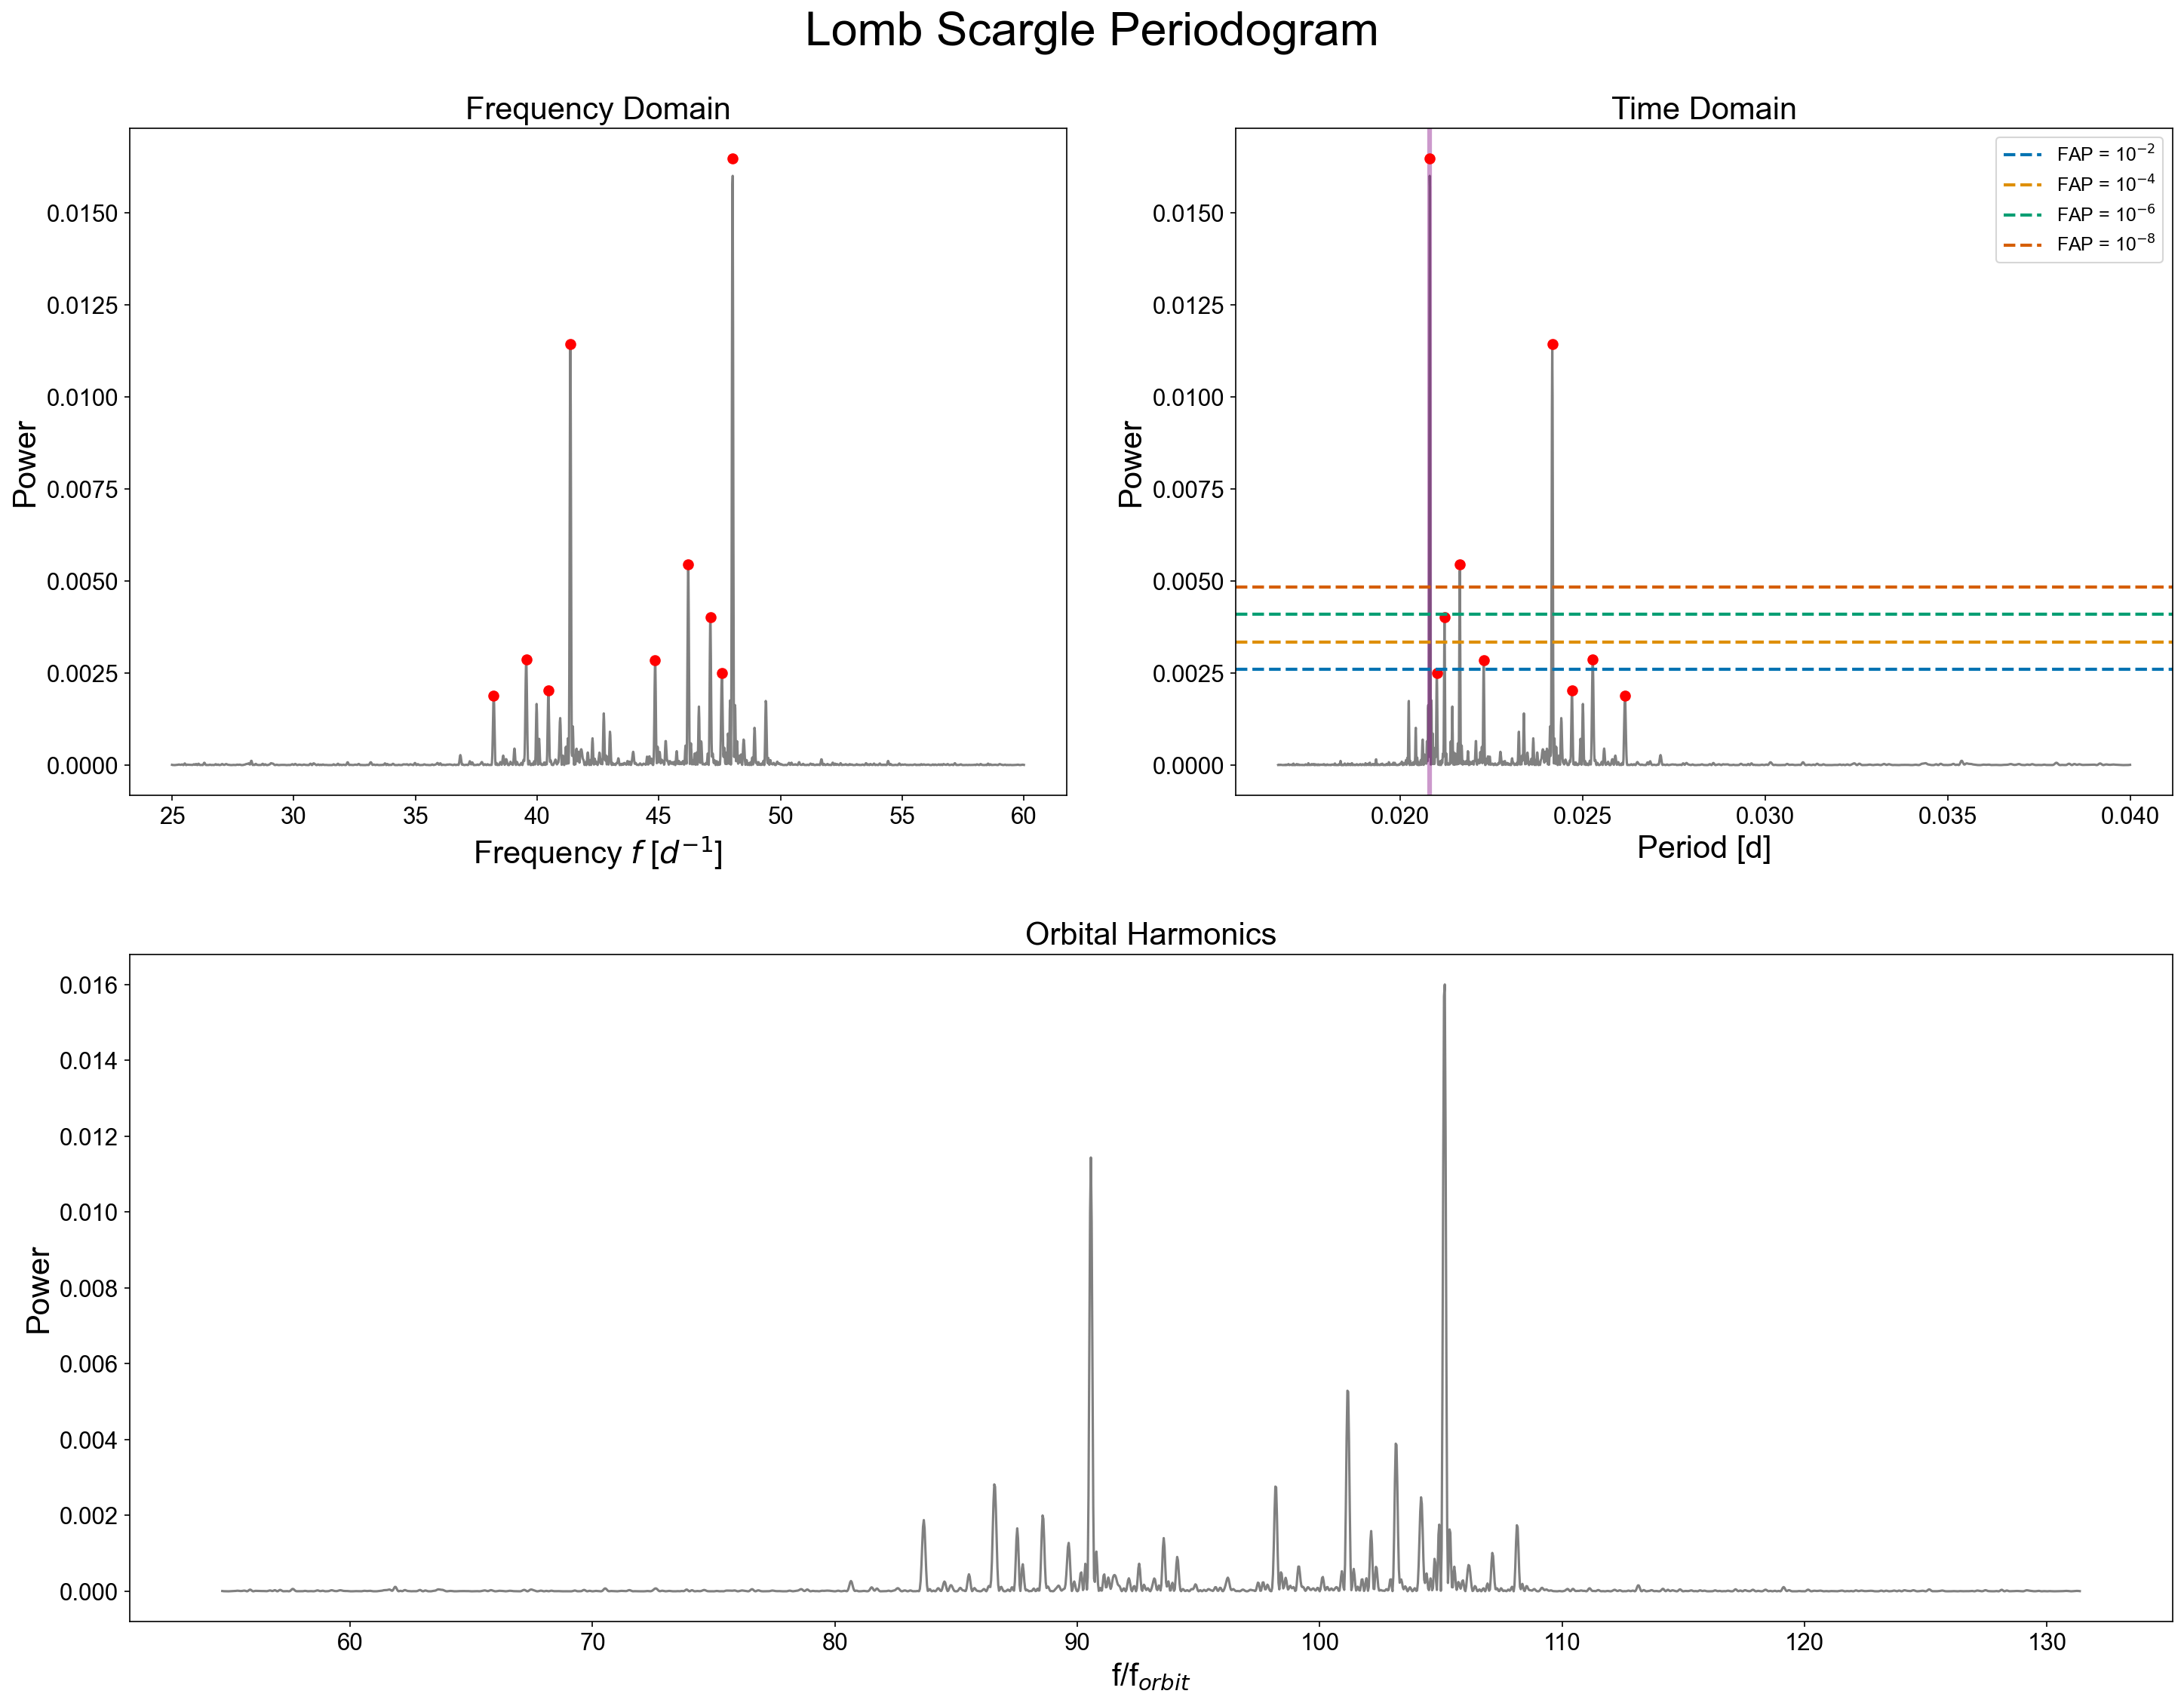

In [29]:
_, freq_osc_0, power_osc_0 = find_oscillations(x[mask], resid[mask], 10, min_freq, max_freq, None)

# Define the Model 

In [147]:
def build_model(time, flux, map_pr, osc_freqs, mask=None):
    
    print("\n----->  Printing best initial guesses\n")
    print("P = %0.06f d" %map_pr['period'])
    print("t0 = %0.06f d" %map_pr['t0'])
    print("sigma = %0.04f\nS_tot = %0.04f\nell = %0.04f" %(map_pr['sigma_lc'], map_pr['S_tot_lc'], map_pr['ell_lc']))
    print("b = %0.04f" % map_pr['b'])
    
    if mask is None:
        mask = np.ones_like(x, dtype=bool)
    
    with pm.Model() as model:
        
        print("\n----->  Initializing the model\n")
        # Systemic parameters
        u1 = xo.QuadLimbDark("u1")
        u2 = xo.QuadLimbDark("u2")

        # Parameters describing the primary: could include priors based on isochrones or similar
        M1 = pm.Lognormal("M1", mu=0.0, sigma=10.0)
        R1 = pm.Lognormal("R1", mu=0.0, sigma=10.0) 

        # Secondary ratios
        k = pm.Lognormal("k", mu=0.0, sigma=10.0)  # radius ratio R2/R1
        q = pm.Lognormal("q", mu=0.810, sigma=0.01)  # mass ratio M2/M1
        s = pm.Lognormal("s", mu=np.log(0.5), sigma=10.0)  # surface brightness ratio S2/S1

        # Parameters describing the orbit
        b = xo.ImpactParameter("b", ror=k, testval=map_pr['b'])
        period = pm.Lognormal("period", mu=np.log(map_pr['period']), sigma=1.0) #np.log(lit_period)
        t0 = pm.Normal("t0", mu=map_pr['t0'], sigma=1.0) #lit_t0

        # Parameters describing the eccentricity: ecs = [e * cos(w), e * sin(w)]
        ecosw = 0.25 * np.pi * (2 * (second_phase + lit_period) / lit_period - 1)
        ecs = xo.UnitDisk("ecs", testval=np.array([ecosw, 0.0]))
        ecc = pm.Deterministic("ecc", tt.sqrt(tt.sum(ecs ** 2)))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))

        # Build the orbit
        R2 = pm.Deterministic("R2", k * R1)
        M2 = pm.Deterministic("M2", q * M1)
        orbit = xo.orbits.KeplerianOrbit(
            period=period,
            t0=t0,
            ecc=ecc,
            omega=omega,
            b=b,
            r_star=R1,
            m_star=M1,
            m_planet=M2,
        )

        # Track some other orbital elements
        pm.Deterministic("incl", orbit.incl)
        pm.Deterministic("a", orbit.a)
        
        # Set up the light curve model
        lc = xo.SecondaryEclipseLightCurve(u1, u2, s)
        model_lc = 1e3 * lc.get_light_curve(orbit=orbit, r=R2, t=time[mask])[:, 0]

        # Oscillation model using frequencies from periodogram
        arg = osc_freqs[None, :] * time[mask, None]
        X = np.concatenate([np.cos(2 * np.pi * arg), np.sin(2 * np.pi * arg),], axis=1)
        
#         w0 = np.linalg.lstsq(X, y[mask])[0]
#         w = pm.Normal("w", mu=0.0, sigma=10.0, shape=len(w0), testval=w0)
#         osc = tt.dot(X, w)
#         osc = tt.zeros(mask.sum())
        
        # Phase curve: mixture of harmonics of the period. 6th order seems to work well based on trial and error
        phi = ((time[mask] - t0) / period) % 1.0
        n_expand = 6
        comps = tt.stack([
            tt.sin(2 * (n + 1) * np.pi * phi)
            for n in range(n_expand)
        ] + [
            tt.cos(2 * (n + 1) * np.pi * phi)
            for n in range(n_expand)
        ], axis=1)
#        amps = pm.Normal("amps", sigma=100.0, shape=2 * n_expand)
#        phase_curve = tt.dot(amps, comps)
        
        # Transit jitter & GP parameters
        sigma_lc = pm.InverseGamma("sigma_lc", testval = map_pr['sigma_lc'], **xo.estimate_inverse_gamma_parameters(0.1, 2.0))
        S_tot_lc = pm.InverseGamma("S_tot_lc", testval = map_pr['S_tot_lc'], **xo.estimate_inverse_gamma_parameters(1.0, 5.0))
        ell_lc = pm.InverseGamma("ell_lc", testval = map_pr['ell_lc'], **xo.estimate_inverse_gamma_parameters(1.0, 5.0)) #0.1,5.0
        kernel_lc = xo.gp.terms.SHOTerm(S_tot=S_tot_lc, w0=2 * np.pi / ell_lc, Q=1.0/3) 
        gp_lc = xo.gp.GP(kernel_lc, time[mask], tt.zeros(mask.sum())** 2 + sigma_lc**2)

#       def mean_model(t):
#           return mean_lc + osc + phase_curve + model_lc(t)
        
        D = tt.concatenate((X, comps, tt.ones((mask.sum(), 1))), axis=1)
        DT = D.T
        DTD = tt.dot(DT, gp_lc.apply_inverse(DT.T)) + 0.01**2 * tt.eye(2 * (len(osc_freqs) + n_expand) + 1)
        
        DTD_det_print = tt.printing.Print("DTD_det")(tt.nlinalg.det(DTD))
        
        DTy = tt.dot(DT, gp_lc.apply_inverse((flux[mask] - model_lc)[:, None]))
        factor = tt.slinalg.cholesky(DTD)
        weights = tt.slinalg.solve_upper_triangular(factor.T, tt.slinalg.solve_lower_triangular(factor, DTy))[:, 0]
        #weights = tt.slinalg.solve(DTD, DTy)[:, 0]
        w = pm.Deterministic("w", weights[:2 * len(osc_freqs)])
        
        osc = tt.dot(X, w)
        amps = pm.Deterministic("amps", weights[2 * len(osc_freqs):2 * n_expand + 2 *len(osc_freqs)])
        phase_curve = tt.dot(comps, amps)
        mean_lc = pm.Deterministic("mean_lc", weights[-1]) 
        
#       # Condition the light curve model on the data
#         gp_lc = xo.gp.GP(
#             kernel_lc, x[mask], tt.zeros(mask.sum()) ** 2 + sigma_lc ** 2, mean=mean_model
#         )
        
        gp_lc.marginal("obs_lc", observed=flux[mask] - tt.dot(D, weights) - model_lc)
        pm.Deterministic("gp_pred", gp_lc.predict())

        # Optimize the logp to obtain the maximum a posteriori parameters given the simuated dataset
        map_soln = model.test_point
        map_soln = xo.optimize(map_soln, vars=[R1, k, s, b, u1, u2])
        #map_soln = xo.optimize(map_soln, [amps])
        #map_soln = xo.optimize(map_soln, [w])
        map_soln = xo.optimize(map_soln, vars=[S_tot_lc, ell_lc,sigma_lc])
        map_soln = xo.optimize(map_soln) 

        model.osc = osc
        model.phase_curve = phase_curve
        model.gp_lc = gp_lc
        model.model_lc = model_lc
        model.x = time[mask]
        model.y = flux[mask]

    return model, map_soln

In [156]:
cdict = {"lc": "cornflowerblue", "gp_pred": "orange", "pc": "green", "osc": "crimson", "zoom": "navy"}
legend_fsize = 22

def evaluate_model(flux, best_model, map_solution, i, plot_bool):
    print("\n-----> Obtaining maximum a posteriori parameters ")
    
    with best_model:
        gp_pred = xo.eval_in_model(best_model.gp_lc.predict(), map_solution) + map_solution["mean_lc"]
        lc = xo.eval_in_model(best_model.model_lc, map_solution)
        osc, pc = xo.eval_in_model([best_model.osc, best_model.phase_curve], map_solution)
        
    model_residuals = flux - lc - pc - osc #- gp_pred
    x_fold = (best_model.x - map_solution["t0"]) % map_solution["period"] / map_solution["period"]
    inds = np.argsort(x_fold)    
    
    if plot_bool == True:
        fig = plt.figure(figsize=(30,28))
        
        #fig.suptitle("MAP Model - Iteration %s" %i, fontsize=35,y=1.2)
    
        fig.subplots_adjust(hspace=0.8)
        ax00 = fig.add_subplot(421)
        ax01 = fig.add_subplot(422)
        ax10 = fig.add_subplot(423)
        ax11 = fig.add_subplot(424)
        ax20 = fig.add_subplot(425)
        ax21 = fig.add_subplot(426)
        ax30 = fig.add_subplot(414)
        
        ax00.plot(best_model.x, best_model.y, "k.", alpha=0.5, label = 'Observed LC')
        ax00.plot(best_model.x, lc, c=cdict["lc"], label = 'Eclipse Model')
        ax00.plot(best_model.x, gp_pred, c=cdict["gp_pred"], lw=2, label = 'GP Model')
        ax00.plot(best_model.x, pc, c=cdict["pc"], label = 'Phase Curve Model')
        ax00.plot(best_model.x, osc, c=cdict["osc"], label = 'Oscillation Model')
        ax00.legend(fontsize=legend_fsize, loc='lower left')
        ax00.set_title("MAP Model LC",fontsize=30)
        ax00.set(
            xlabel = "Time [KBJD]", 
            ylabel="Raw flux [ppt]"
        );
        
        ax01.plot(best_model.x, osc, c=cdict["osc"], alpha=0.8,label = "Oscillation Model")
        ax01.plot(best_model.x, model_residuals, c='lightsteelblue', alpha=0.8, label = 'Residuals = Observed LC - (Eclipse Model + PC Model + Osc. Model)')
        ax01.plot(best_model.x, gp_pred, marker='.', c=cdict["gp_pred"], alpha=0.8, label = "GP Model")
        ax01.set(
            xlabel = "Time [KBJD]", 
            ylabel="Flux [ppt]"
        );
        ax01.set_title("Light Curve Residuals",fontsize=30)
        ax01.legend(fontsize=legend_fsize)
        
        ax10.plot(best_model.x, best_model.y, "k.", alpha=0.2, label = 'Observed LC')
        ax10.plot(best_model.x, osc, c=cdict["osc"], label = 'Oscillations Model')
        ax10.plot(best_model.x, pc, c=cdict["pc"], lw=2, label = 'Phase Curve Model')
        ax10.plot(best_model.x, gp_pred, c=cdict["gp_pred"], label = 'GP Model')
        ax10.axvspan(294, 296, facecolor=cdict["zoom"], alpha=0.05, label='Zoomed Region')
        ax10.legend(fontsize=legend_fsize)
        ax10.set(
            xlim = (best_model.x.min(), best_model.x.max()), 
            ylim = (-10, 15), 
            xlabel = "Time [KBJD]", 
            ylabel="Raw flux [ppt]",
            title = "MAP Model LC"
        );
        
        ax11.plot(best_model.x, best_model.y, "k.", alpha=0.2, label = 'Observed LC')
        ax11.plot(best_model.x, osc, c=cdict["osc"], lw=2, label = 'Oscillations Model')
        ax11.plot(best_model.x, pc, c=cdict["pc"], lw=2, label = 'Phase Curve Model')
        ax11.plot(best_model.x, gp_pred, c=cdict["gp_pred"], lw=2, label = 'GP Model')
        ax11.axvspan(294, 296, facecolor=cdict["zoom"], alpha=0.05, label='Zoomed Region')
        ax11.legend(fontsize=legend_fsize)
        ax11.set(
            xlim = (294,296), 
            ylim = (-10, 15), 
            xlabel = "Time [KBJD]", 
            ylabel="Raw flux [ppt]",
            title = "MAP Model LC (Zoomed-in)"
        );
        
        ax20.plot(best_model.x, best_model.y - lc - pc - gp_pred, "k.", alpha=0.2, 
                 label = 'Observed LC - (Eclipse Model + PC Model + GP. Model)') #
        ax20.plot(best_model.x, osc, c=cdict["osc"], label = "Oscillations Model")
        ax20.axvspan(294, 296, facecolor=cdict["zoom"], alpha=0.1,label='Zoomed Region')
        ax20.legend(fontsize=legend_fsize, loc="upper right")
        ax20.set(
            xlabel = "Time [KBJD]", 
            ylabel="Raw Flux [ppt]",
            xlim = (best_model.x.min(), best_model.x.max()),
            title = "Oscillation Model"
        );
        
        ax21.plot(best_model.x, best_model.y - lc - pc - gp_pred, "k.", alpha=0.2, 
                 label = 'Observed LC - (Eclipse Model + PC Model + GP Model)') #
        ax21.plot(best_model.x, osc, c=cdict["osc"], label = "Oscillations Model")
        ax21.axvspan(294, 296, facecolor=cdict["zoom"], alpha=0.1, label='Zoomed Region')
        ax21.set(
            xlabel = "Time [KBJD]",
            ylabel="Raw Flux [ppt]", 
            xlim=(294,296),
            title = "Oscillation Model (Zoomed-in)"
        );
        ax21.legend(fontsize=legend_fsize,loc="upper right")
        
        ax30.plot(x_fold[inds], best_model.y[inds] - gp_pred[inds] - osc[inds], "k.", alpha=0.2, label = 'Observed LC - (GP Model + Oscillation Model)')
        ax30.plot(x_fold[inds] - 1, best_model.y[inds] - gp_pred[inds] - osc[inds], "k.", alpha=0.2)
        ax30.plot(x_fold[inds], lc[inds], c = cdict["lc"], lw=2, label = "Eclipse Model")
        ax30.plot(x_fold[inds] - 1, lc[inds], c = cdict["lc"], lw=2)
        ax30.plot(x_fold[inds], pc[inds], c = cdict["pc"], lw=2)
        ax30.plot(x_fold[inds] - 1, pc[inds], c = cdict["pc"], lw=2, label = "Phase Curve Model")
        ax30.legend(fontsize=legend_fsize)
        ax30.set(
            xlim=(-1, 1), 
            xlabel = "Phase", 
            ylabel = "De-trended flux [ppt]",
            title = "Detrended Light Curve"
        );
        
        fig.tight_layout()
        fig.savefig("map_model_"+i+".png")

        plt.pause(0.05); plt.close("all")
    
    return model_residuals, osc, gp_pred, pc, lc

# Iterative Process to Search for New Oscillation Frequencies

Define variables to store results of the search and start `while` loop (todo: while loop + stop when we reach SNR threshold)


               ITERATION 1
*******************************************

----->  Printing best initial guesses

P = 2.189094 d
t0 = 629.006137 d
sigma = 1.0000
S_tot = 2.5000
ell = 2.0000
b = 1.5000

----->  Initializing the model

DTD_det __str__ = 3.681865040062822e+107


optimizing logp for variables: [u2, u1, b, k, s, R1]


message: Desired error not necessarily achieved due to precision loss.
logp: -9552857.259433204 -> -227254.56094528842
optimizing logp for variables: [sigma_lc, ell_lc, S_tot_lc]


message: Desired error not necessarily achieved due to precision loss.
logp: -227254.56094528842 -> -1585.9121804577128
optimizing logp for variables: [ell_lc, S_tot_lc, sigma_lc, ecs, t0, period, b, s, q, k, R1, M1, u2, u1]




-----> Obtaining maximum a posteriori parameters 


message: Desired error not necessarily achieved due to precision loss.
logp: -1585.9121804577128 -> 842.3215881446915


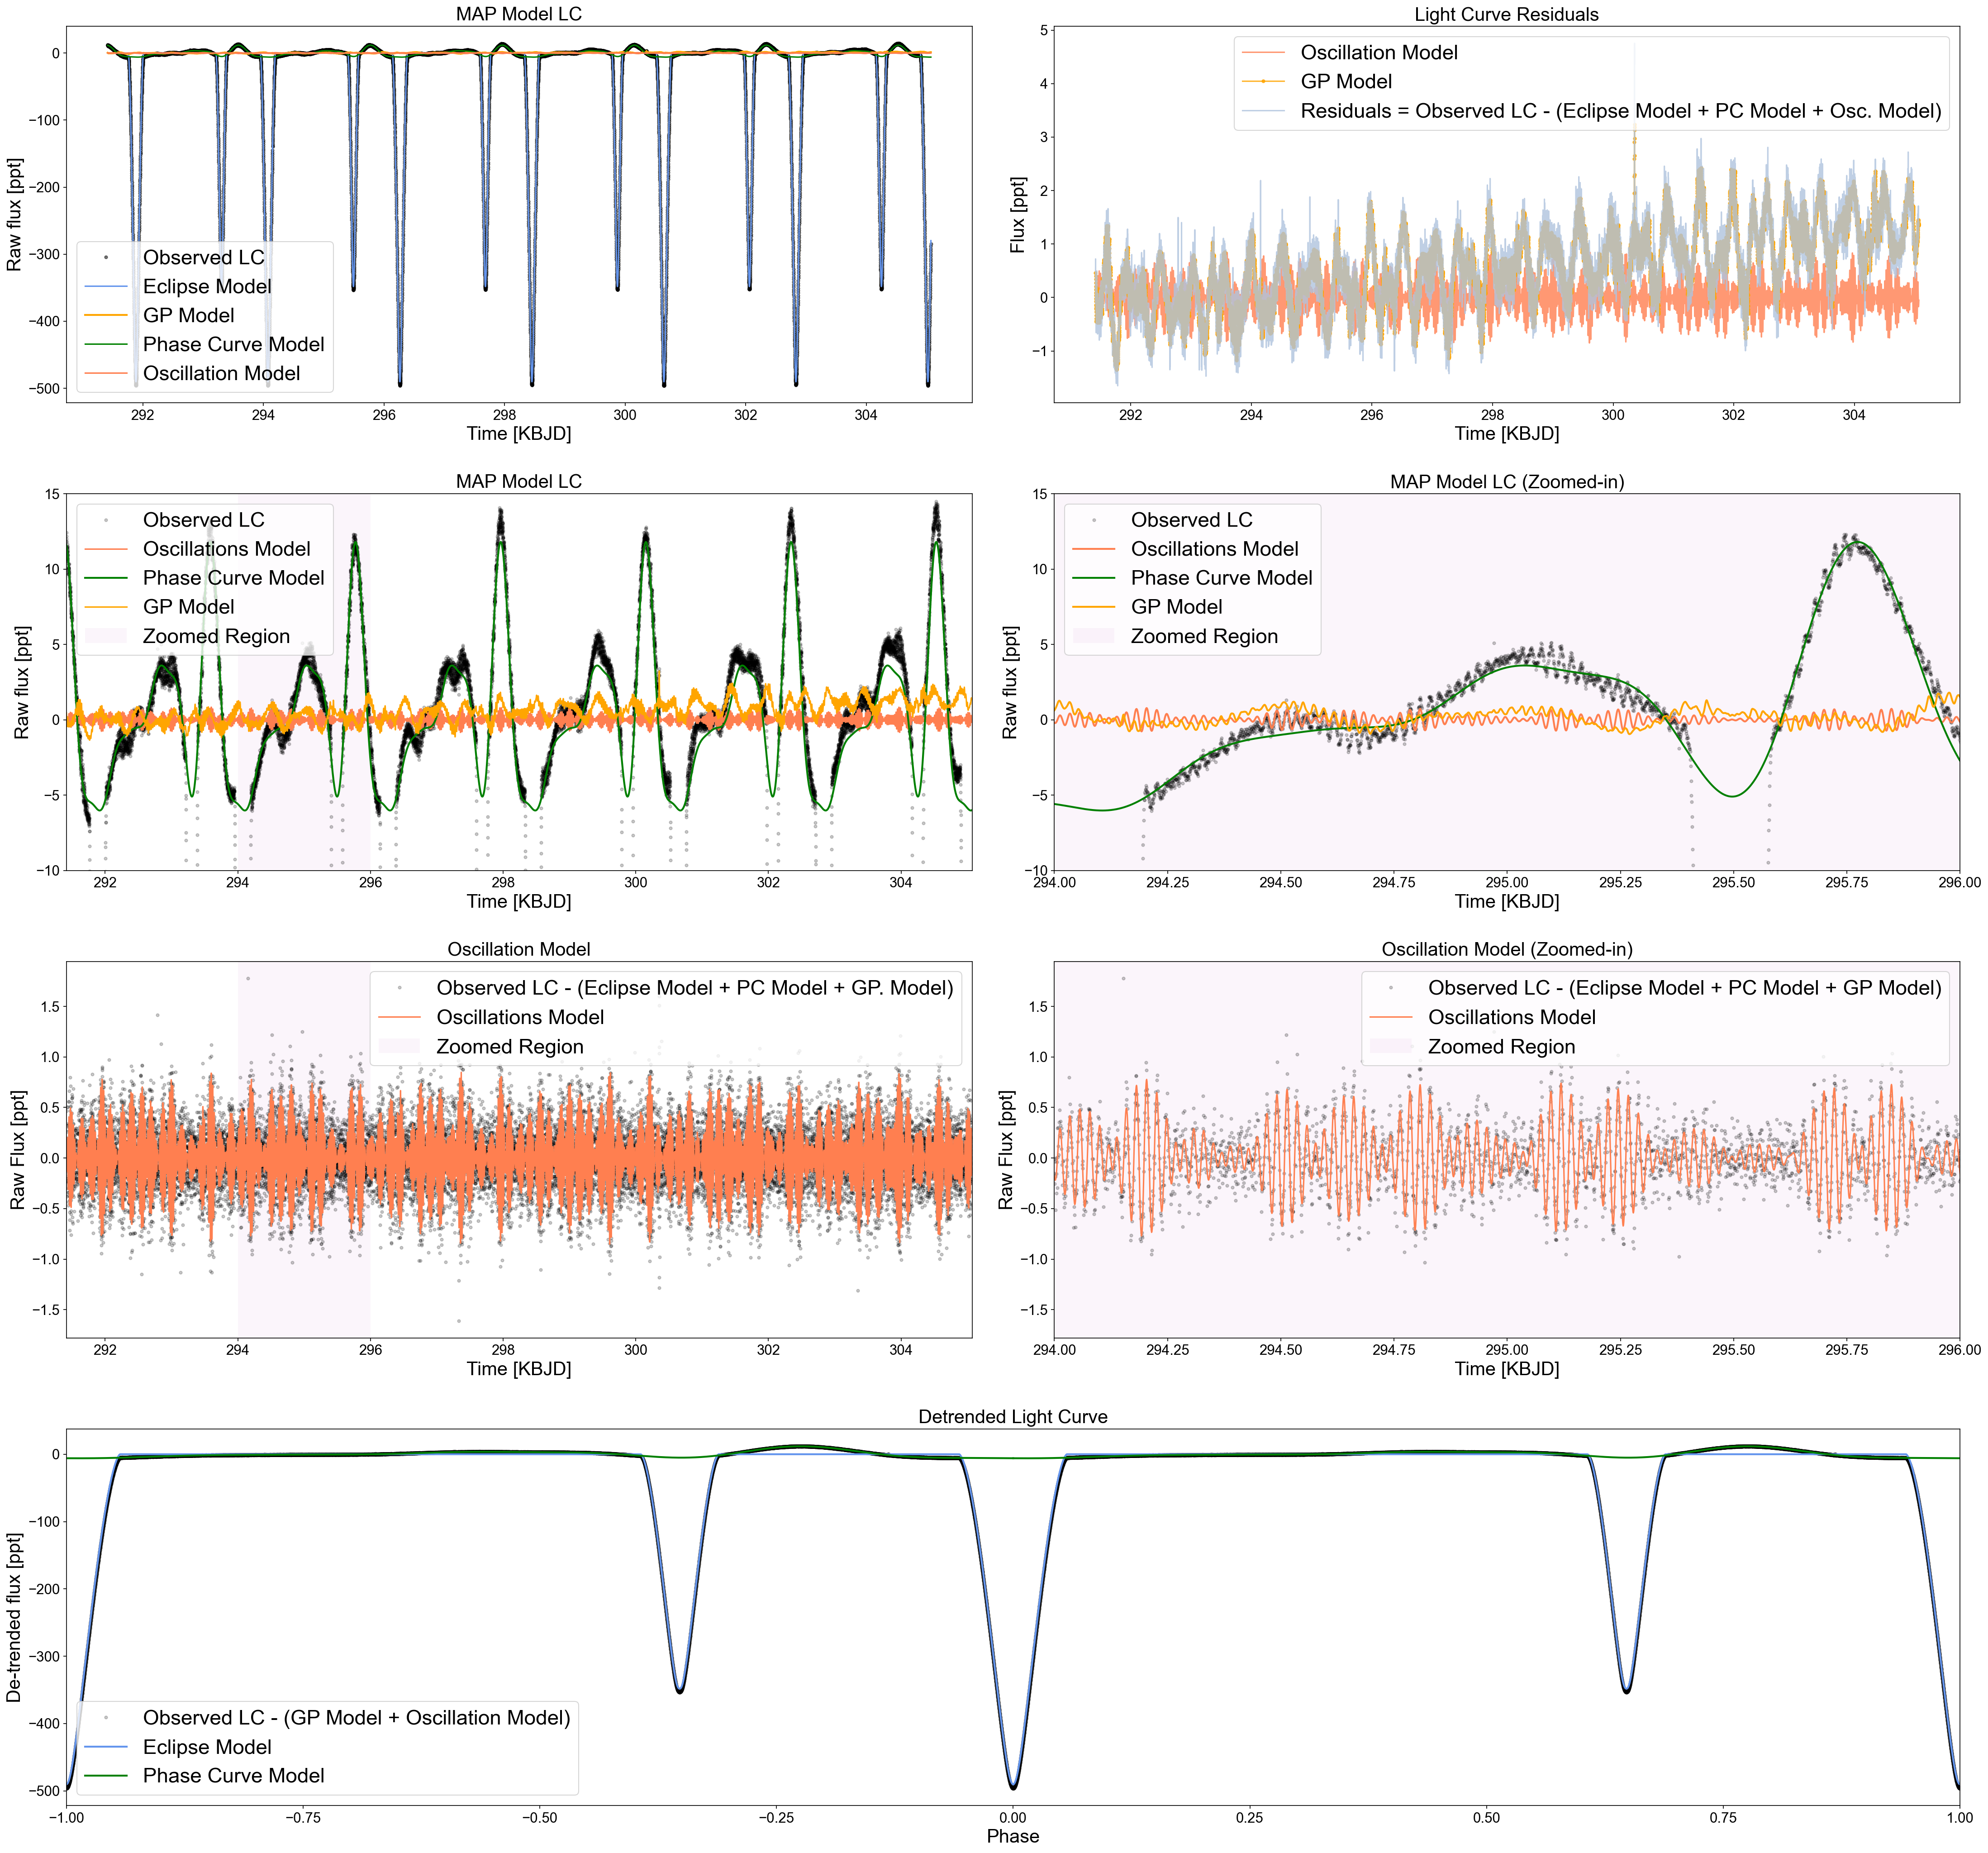

--> I have found 7 frequencies
f = 44.31 1/d --> 0.0226 days, 0.54 hours, 32.50 min, 1949.80 sec
f = 47.97 1/d --> 0.0208 days, 0.50 hours, 30.02 min, 1800.97 sec
f = 46.58 1/d --> 0.0215 days, 0.52 hours, 30.91 min, 1854.87 sec
f = 44.78 1/d --> 0.0223 days, 0.54 hours, 32.16 min, 1929.50 sec
f = 43.41 1/d --> 0.0230 days, 0.55 hours, 33.17 min, 1990.40 sec
f = 46.15 1/d --> 0.0217 days, 0.52 hours, 31.20 min, 1872.30 sec
f = 43.00 1/d --> 0.0233 days, 0.56 hours, 33.48 min, 2009.08 sec

--> I have found 0 resonant frequencies!


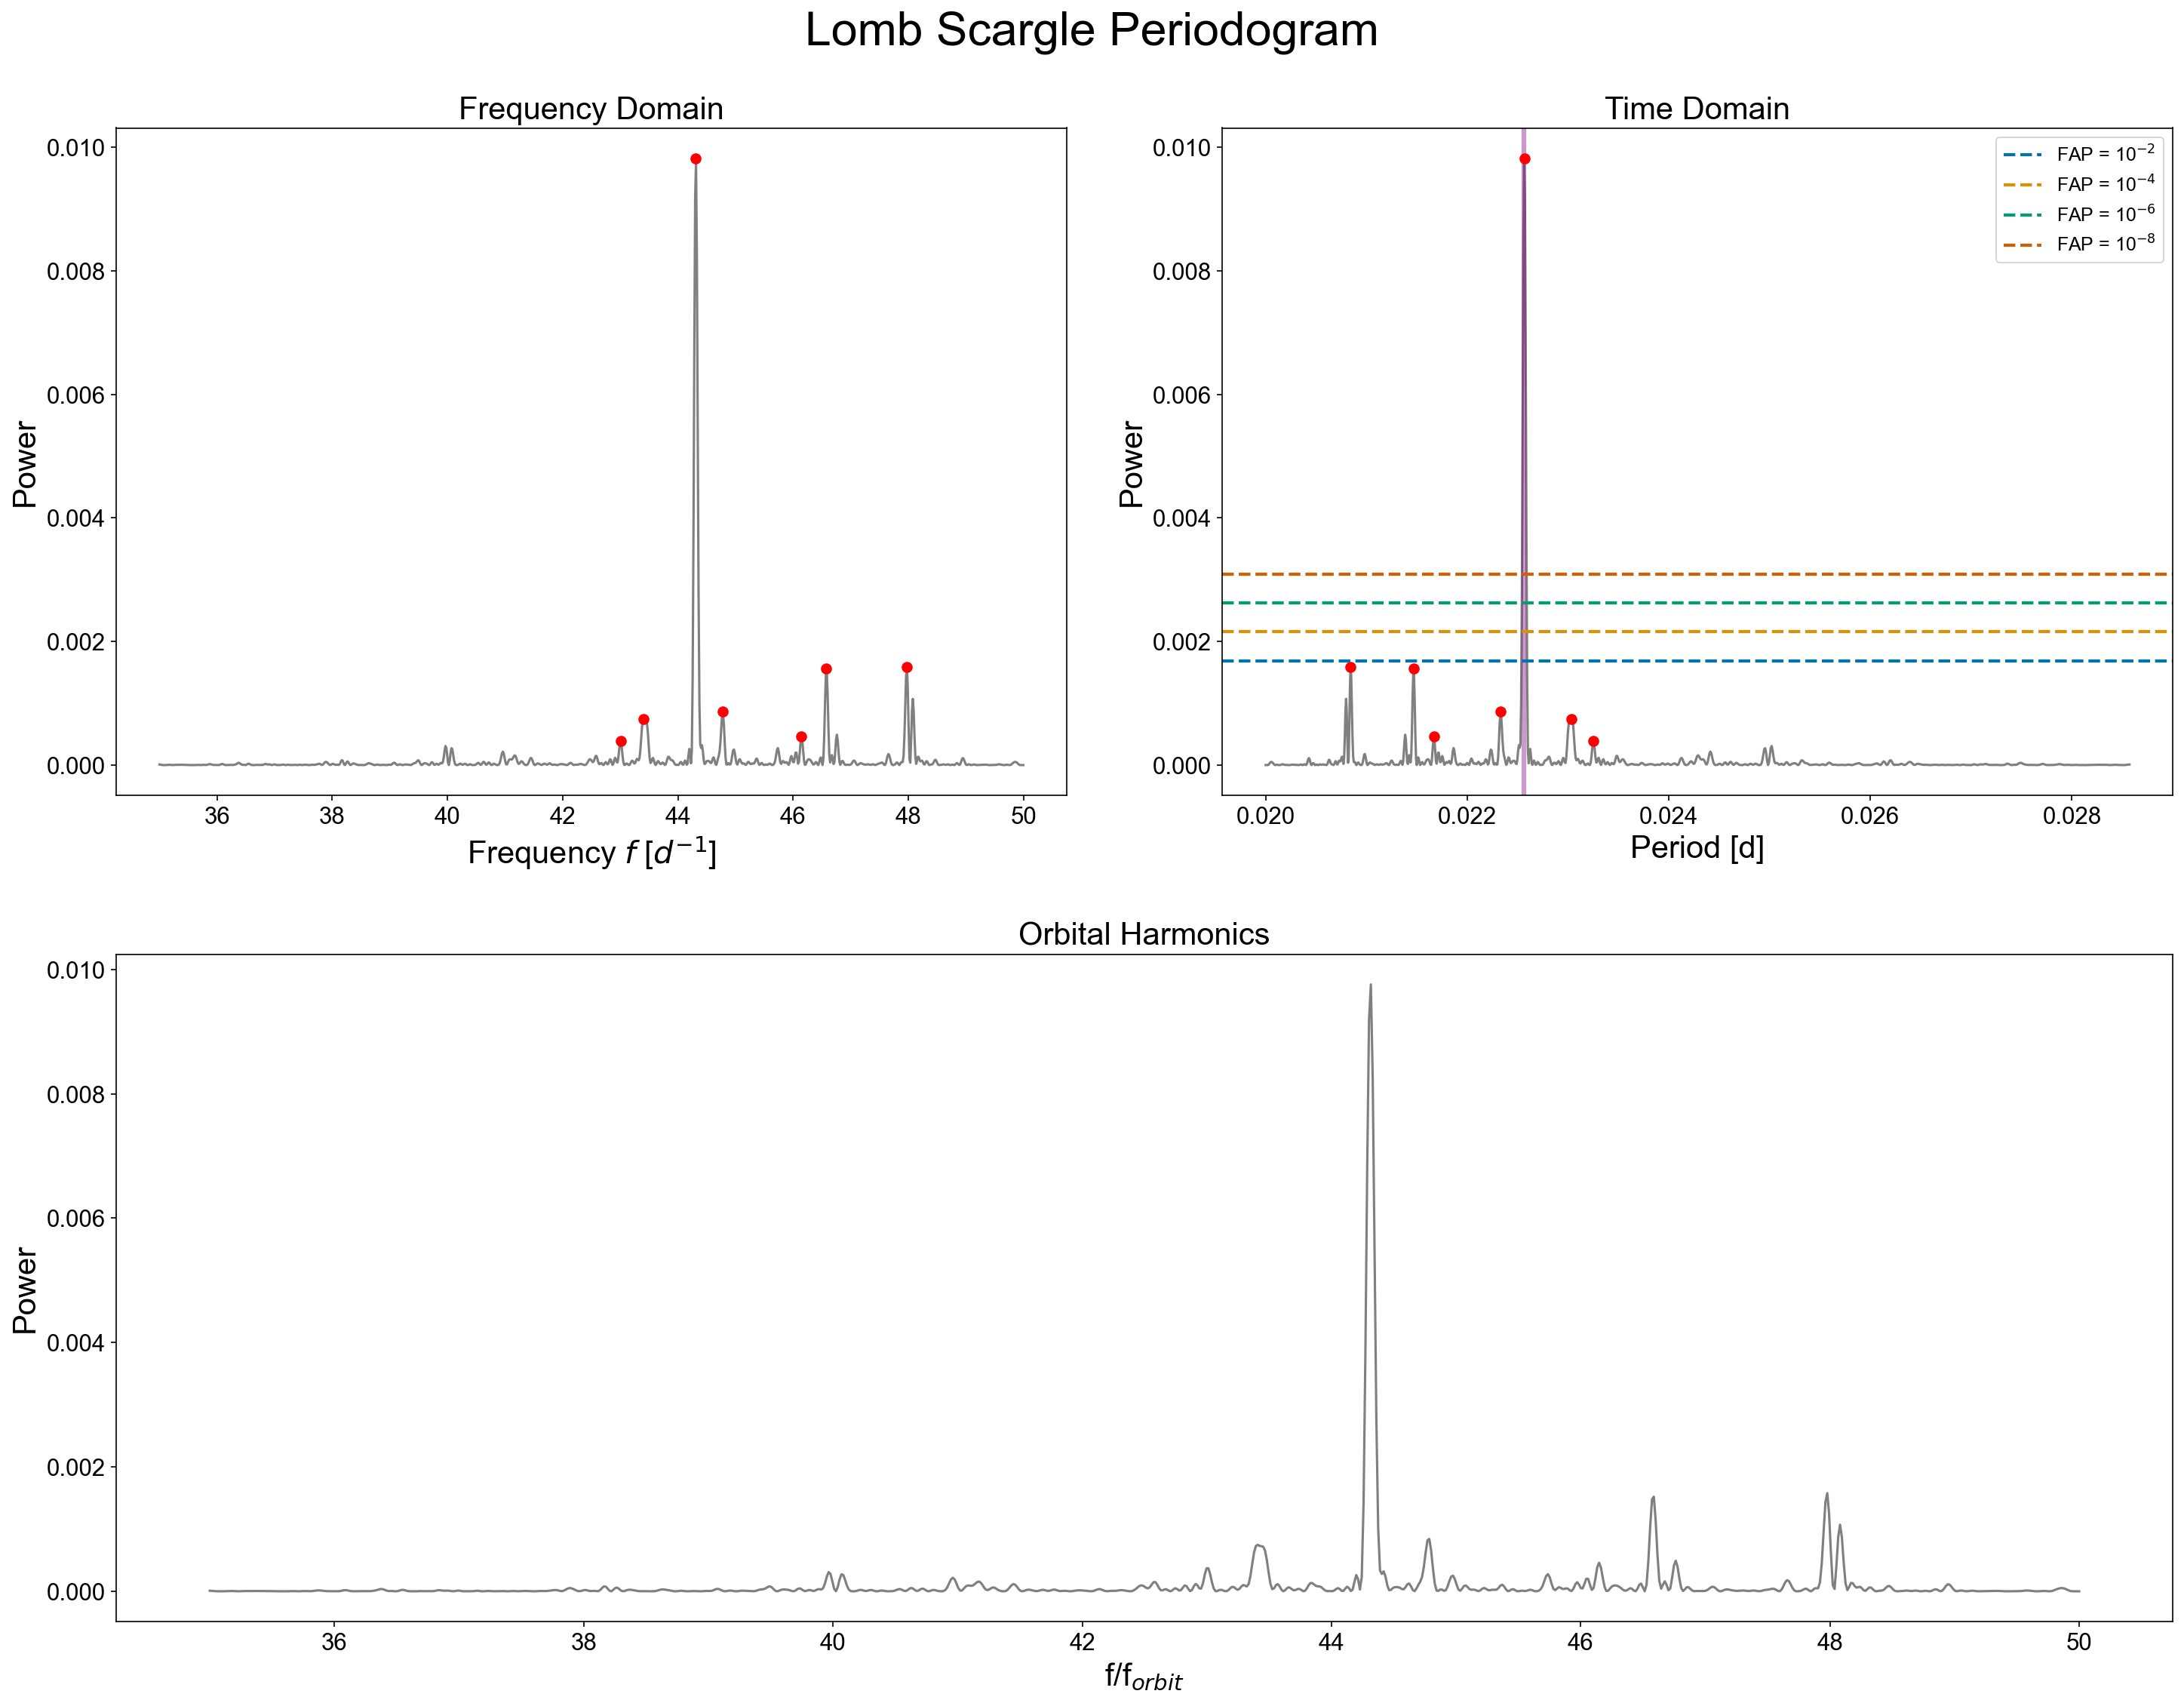


               ITERATION 2
*******************************************

               ITERATION 3
*******************************************

               ITERATION 4
*******************************************

               ITERATION 5
*******************************************


In [149]:
plot_bool = True # False if you don't want to see MAP model plots. 
map_results = {} #store MAP modplot_bool = True # False if you don't want to see MAP model plots. el 
ls_results = {}

#Store MAP for the model components (to be improved: directly access them via best model)
osc_models = {} 
gp_models = {}
pc_models = {}
lc_models = {}

for i in range(1,6):
    print("\n               ITERATION %s\n*******************************************" %i)
    if i == 1: 
        #mod_i, map_i = sigma_clip(x, y, freq_osc_0) 
        
        #Initialize the Model
        ls_results[i] = [freq_osc_0, power_osc_0] #initial freqs
        
        #Initial values
        map_0 = {
            'period': lit_period,
            't0': lit_t0,
            'b': 1.5, 
            'sigma_lc': 1.0, 
            'S_tot_lc': 2.5, 
            'ell_lc': 2.0} 
        
        mod_i, map_i = build_model(x, y, map_0, freq_osc_0,None) 
        
        #Calculate model residuals & plot MAP
        residuals, best_osc, best_gp, best_pc, best_lc = evaluate_model(y, mod_i, map_i, str(i), plot_bool)
        
        #Run periodogram of the residuals
        _, freq_osc_i, power_osc_i = find_oscillations(x, residuals, 10,  min_freq, max_freq, str(i))
        
    '''    
    elif (i > 1) and (len(freq_osc_i)!=0): 
        #mod_i, map_i = sigma_clip(x, residuals, freq_osc)
        
        ls_results[i] = [freq_osc_i, power_osc_i]
        
        freq_osc_cumulative, _ = np.hstack([(freqs, powers) for (freqs,powers) in ls_results.values()])
        print("Accumulated frequencies:", len(freq_osc_cumulative))
        
        mod_i, map_i = build_model(x, y, map_i, freq_osc_cumulative,None) 
        
        residuals, best_osc, best_gp, best_pc, best_lc = evaluate_model(y, mod_i, map_i, str(i), plot_bool)
        
        _, freq_osc_i, power_osc_i = find_oscillations(x, residuals, 10,  min_freq, max_freq, str(i))

    else: 
        #(I'll have find a better way to tell the code when to stop the iterations)
        print("The last periodogram does not show more significant frequencies.") 
    '''
    #Store the results
    map_results[i] = map_i
    osc_models[i] = best_osc
    gp_models[i] = best_gp
    pc_models[i] = best_pc
    lc_models[i] = best_lc

In [ ]:
for i, map_sol in map_results.items():
    print(i, map_sol['w'])
    print("")    
    print(map_sol['amps'])
    print("")


-----> Obtaining maximum a posteriori parameters 


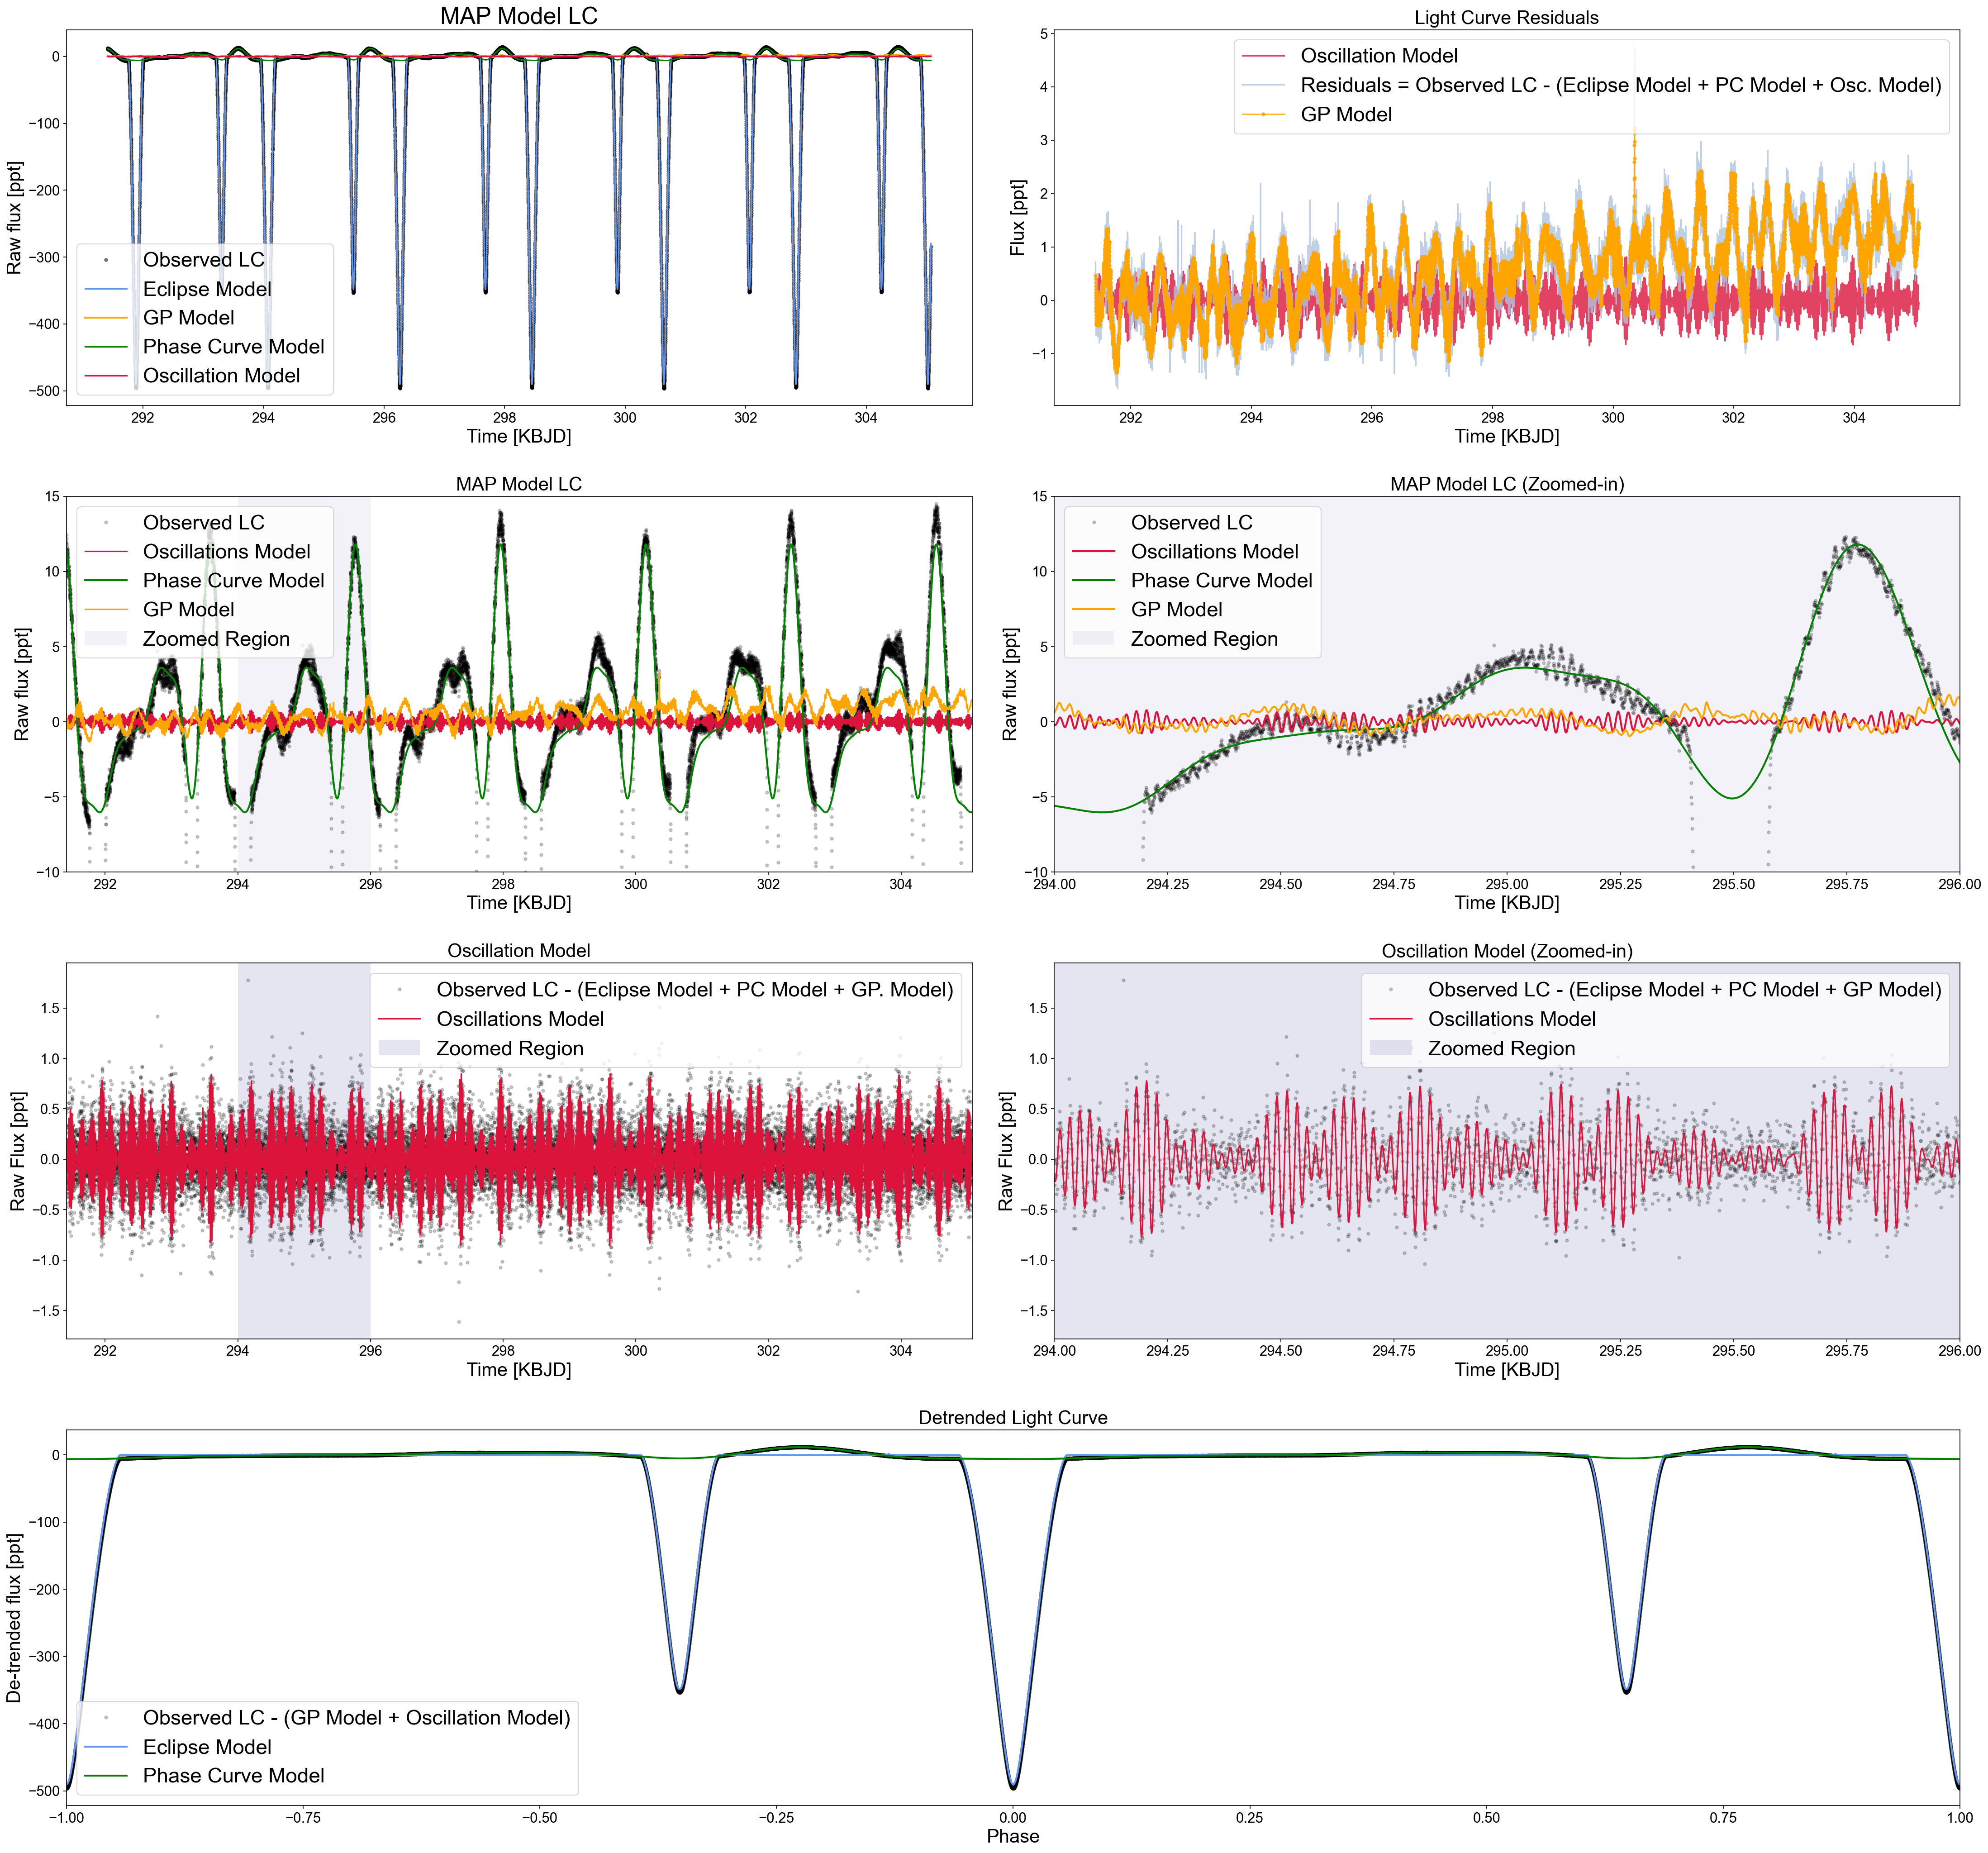

In [155]:
residuals, best_osc, best_gp, best_pc, best_lc = evaluate_model(y, mod_i, map_i, str(i), plot_bool)

# Plot best oscillation models 

In [ ]:
osc_palette = sns.color_palette("coolwarm");

fig, ax = plt.subplots(1,1)
y_shift = 0.0
for m in osc_models:
    nfreq=len(ls_results[m][0])
    ax.plot(x, osc_models[m]+y_shift, c=osc_palette[m], label = r"Iteration %s ($n_{freq}$ = %s)" %(m,nfreq))
    y_shift+=2.

ax.set(xlabel = "Time [KBJD]", ylabel = r"Raw Flux$^{\dagger}$ [ppt]", title="Oscillation Models");
ax.text(x.min()-1,-3,r"$\dagger$: Flux shifted so that the models do not overlap with each other. ",c='crimson',fontsize=8)
plt.legend(fontsize=12)

In [ ]:
np.random.seed(4544587)
with model:
    trace = pm.sample(
        #tune=1000,
        #draws=1000,
        tune = 500,
        draws = 1000,
        start=map_soln,
        chains=2,
        target_accept=0.95,
    )

In [ ]:
pm.summary(trace)

In [ ]:
idata = az.from_pymc3(trace) 
idata.to_netcdf('results.nc')

In [ ]:
az.summary(idata)

In [ ]:
pm.model_graph.model_to_graphviz(model)

In [ ]:
pm.traceplot(trace);

In [ ]:
plt.plot(trace["a"])